In [1]:
import copy
import time, importlib
import h5py
import numpy as np
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import kalepy as kale

In [3]:
import matplotlib
import matplotlib.colors
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects

In [4]:
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.config as l_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting

In [7]:
import coolingFunction

In [8]:
import trove
import verdict
from py2tex import py2tex

In [9]:
import helpers

In [10]:
%matplotlib inline
matplotlib.style.use( '~/repos/clean-bold/clean-bold.mplstyle' )

# Parameters

## Manual

In [11]:
pm = dict(
    snum = 600,
    ahf_index = 600,
)

In [12]:
global_variations = [
    '',
    'track_all_thin_disk_stars',
    'track_all_recent_stars',
]

In [13]:
labels = [
    'main sample',
    r'all stars with $j_z/j_c(E) > 0.8$',
    r'all stars with age $<1$ Gyr',
]

In [14]:
cmap = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
colors = [ cmap[0], cmap[1], cmap[3] ]

## Looped

In [15]:
pms = [
    trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        script_id = 'nb.8',
        variation = 'm12i_md',
        global_variation = _,
        **pm
    ) for _ in global_variations
]

# Load Data

In [16]:
ws = [
    a_worldlines.Worldlines(
        tag = pm['tag'],
        data_dir = pm['data_dirs']['jug.4'],
        halo_data_dir = pm['halo_data_dir'],
        ahf_index = pm['ahf_index'],
    ) for pm in pms
]

# Calculate Accretion and cooling time

## Times

In [23]:
taccs[0].size

37189

In [17]:
taccs = []
tcoolss = []

for i, pm in enumerate( pms ):
    
    print(  'Global variation: {}'.format( global_variations[i] ) )

    tacc_inds = ws[i].calc_tacc_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
    )

    tcools_inds = ws[i].calc_tcools_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
        B = pm['logTcools'],
    )

    valid = ( tacc_inds != l_config.INT_FILL_VALUE ) & ( tcools_inds != l_config.INT_FILL_VALUE )
    tacc_inds = tacc_inds[valid]
    tcools_inds = tcools_inds[valid]
    particle_inds = np.arange( ws[i].n_particles )[valid]

    tacc = ws[i].get_data( 'tacc' )[particle_inds]
    tcools = ws[i].get_data( 'tcools' )[particle_inds]
    
    taccs.append( tacc )
    tcoolss.append( tcools )

Global variation: 


100%|██████████| 45846/45846 [00:02<00:00, 22833.80it/s]


Global variation: track_all_thin_disk_stars


100%|██████████| 100000/100000 [00:41<00:00, 2395.91it/s]


Global variation: track_all_recent_stars


100%|██████████| 100000/100000 [00:48<00:00, 2061.81it/s]


## Time distributions

In [18]:
t_z0 = ws[0].get_data( 'time' )[0]
t_zi = ws[0].get_data( 'lookback_time' )[-1]
t_min = np.nanmin([ np.nanpercentile( np.hstack( taccs ), 1. ), np.nanpercentile( np.hstack( tcoolss ), 1. ) ])
t_range = [ t_min, t_z0 ]
t_bins = np.arange( t_range[0], t_range[1], 0.065 )
t_centers = 0.5 * ( t_bins[:-1] + t_bins[1:] )

In [19]:
pdfs = {
    'tacc': [],
    'tcools': [],
}
cdfs = {
    'tacc': [],
    'tcools': [],
}
kdes = {
    'tacc': [],
    'tcools': [],    
}
for i, pm in enumerate( tqdm.tqdm( pms ) ):
    keys = [ 'tacc', 'tcools' ]
    for j, tchange in enumerate([ taccs, tcoolss ]):
    
        pdf, bins = np.histogram(
            tchange[i],
            bins = t_bins,
            density = True,
        )
        pdfs[keys[j]].append( pdf )

        cdf = np.cumsum( pdf )
        cdf /= cdf[-1]
        cdfs[keys[j]].append( cdf )
        
        points, kde = kale.density(
            tchange[i],
            points = t_centers,
            reflect = [ 0, t_z0 ],
            probability = True,
        )
        kdes[keys[j]].append( kde )

100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


# Plot time distributions

## Settings

In [20]:
x_annots = {
    'tacc': [ 13.05, 11, 12.6 ],
    'tcools': [ 12.9, 9.2, 12 ],
}

## Plot

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/selected_to_all_comparison/tacc_m12i_md.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/selected_to_all_comparison/tcools_m12i_md.pdf


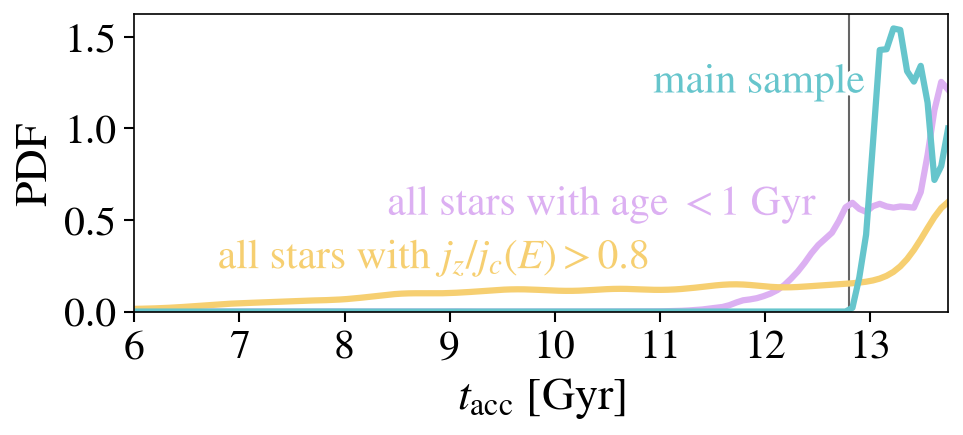

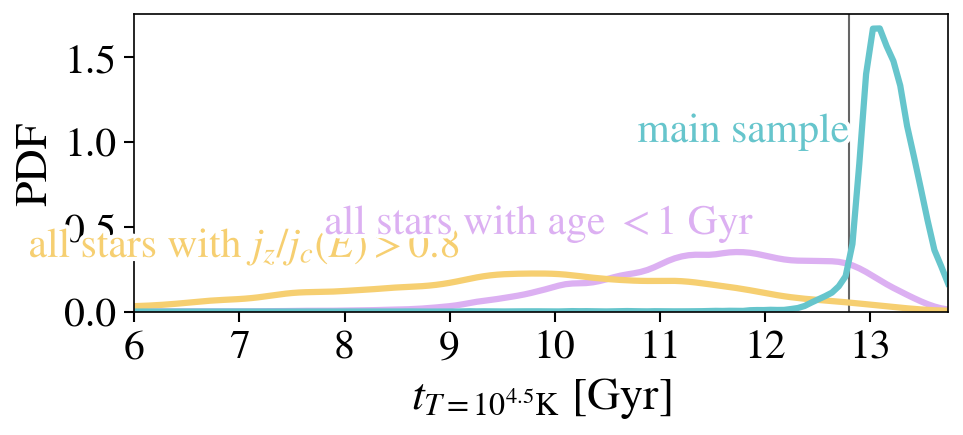

In [25]:
for k, t_key in enumerate([ 'tacc', 'tcools' ]):

    fig = plt.figure( figsize=(7, 5.25/2) )
    ax = plt.gca()

    for i, pm in enumerate( pms ):
        ax.plot(
            t_centers,
            kdes[t_key][i],
            c = colors[i],
            zorder = -i,
        )

        x_annot = x_annots[t_key][i]
        if x_annot is None:
            x_annot = scipy.interpolate.interp1d( cdfs[t_key][i], t_centers )( 0.5 )
        y_annot = scipy.interpolate.interp1d( t_centers, kdes[t_key][i] )( x_annot )
        text = ax.annotate(
            text = labels[i],
            xy = ( x_annot, y_annot ),
            xytext = ( -5, 5 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'bottom',
            fontsize = 20,
            c = colors[i],
        )
        text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

    ax.set_xticks( np.arange( 0, t_z0, 1. ) )
    ax.set_yticks( np.arange( 0, 5, 0.5 ) )

    ax.set_xlim( 6, t_centers[-1] )
    ax.set_ylim( 0, np.nanmax( kdes[t_key] )*1.05 )
    
    ax.axvline(
        t_z0 - 1.,
        c = pm['background_linecolor'],
        linewidth = 1,
        zorder = -100,
    )

    x_label = (
        helpers.get_tchange_label( pm, central_indices='{}_inds'.format( t_key ) ) +
        ' [Gyr]'
    )
    ax.set_xlabel( x_label, fontsize=22 )
    ax.set_ylabel( 'PDF', fontsize=22 )

    plotting.save_fig(
        out_dir = os.path.join( pms[0]['figure_dir'], 'selected_to_all_comparison' ),
        save_file = '{}_{}.pdf'.format( t_key, pm['variation'] ),
        fig = fig,
    )